This notebook will implement a kNN algorithm from scratch, where we try to categorize different birds from images.

First we import our needed libraries

In [24]:
import cv2
import numpy as np
import os
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
print("Backend:", matplotlib.get_backend())
from skimage.feature import local_binary_pattern

Backend: inline


We then want to separate the bird from the background for easier identification with kNN. This is a function, so it will need to be confined in one cell.
1. Read the file
2. Convert the image to grayscale then blur it. This will help us find the edges in the image so we can separate the bird from the background.
3. Use local binary pattern to further help separate bird from background
4. Saliency highlights high contrasts, further helping separate bird from background
5. Combine the methods above
6. Threshold by turning pixels below 50 in value into 0 and those above to 255, so a binary black and white picture
7. Clean up by using morphology, first expanding and then shrinking white areas to remove gaps and isolated pixels
8. Find contours in image, biggest one should be the bird
9. Make a mask of the image
10. Set what probably is the foreground and what is the background and make a rectangle for the foreground so grabcut can focus on it
11. Create some arrays to store info about the pixels in the image, then use GrabCut to iterate over the image 5 times with the mask. The mask gets updated after each iteration based on the info in arrays.
12. Get the binary mask  be able to apply it to the original image to (hopefully) get the bird separated from its background.
13. Return our necessary values.


In [25]:
def segment_bird(image_path):
    #1
    image = cv2.imread(image_path)
    if image is None:
        return None, None, None, None, None

    #2
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    #3
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(blurred, n_points, radius, method="uniform")
    lbp = (lbp / np.max(lbp) * 255).astype(np.uint8)  # Normalize to 0-255

    #4
    grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    saliency_map = cv2.magnitude(grad_x, grad_y)
    saliency_map = cv2.normalize(saliency_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    #5
    combined = cv2.addWeighted(edges, 0.3, lbp, 0.3, 0)
    combined = cv2.addWeighted(combined, 0.7, saliency_map, 0.3, 0)

    #6
    _, thresh = cv2.threshold(combined, 50, 255, cv2.THRESH_BINARY)

    #7
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    #8
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None, None, None, None, None

    filtered_contours = [c for c in contours if cv2.contourArea(c) > 1000]
    if not filtered_contours:
        return None, None, None, None, None

    largest_contour = max(filtered_contours, key=cv2.contourArea)


    #9
    mask = np.zeros(image.shape[:2], np.uint8)

    #10
    mask[:] = cv2.GC_PR_BGD
    cv2.drawContours(mask, [largest_contour], -1, cv2.GC_PR_FGD, thickness=cv2.FILLED)
    x, y, w, h = cv2.boundingRect(largest_contour)
    rect = (x, y, w, h)

    #11
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

    #12
    final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    segmented = cv2.bitwise_and(image, image, mask=final_mask)

    #13
    return image, gray, edges, saliency_map, segmented

Now to do the preprocessing. We do this to get features from our images that we then can compare to other images in our kNN algorithm.

1. Get segmented bird (we don't want the other returned values for this part)
2. Find the boundary of the bird and crop the bird out
3. Resize to a standard size so we get equal amount of features
4. Flattening is what gives us our features.


In [26]:
def preprocess_for_knn(image_path, target_size=(128, 128)):
    #1
    _, _, _, _, segmented = segment_bird(image_path)
    if segmented is None:
        return None, None

    #2
    gray_segmented = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_segmented, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #3
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        bird_only = segmented[y:y+h, x:x+w]
        resized = cv2.resize(bird_only, target_size)
    else:
        resized = cv2.resize(segmented, target_size)

    #4
    flattened = resized.flatten()
    return resized, flattened

Here is a visualization of the process we just went through. We will use a picture of an american goldfinch for this. We then apply our segment_bird function and extract the properties we want for it to be put into a plot.

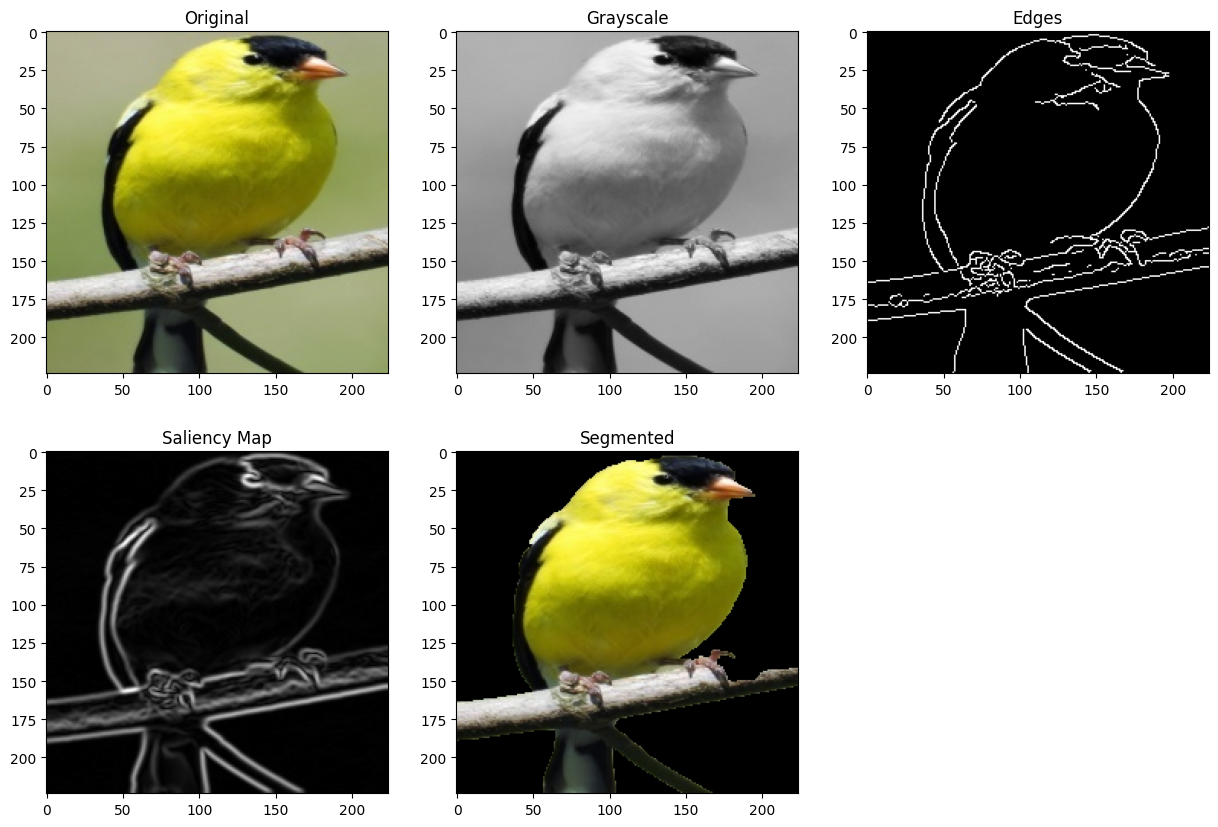

In [28]:
image_path = "data/Bird_Species_Dataset/AMERICAN_GOLDFINCH/AMERICAN_GOLDFINCH_004.jpg"

original, gray, edges, saliency_map, segmented = segment_bird(image_path)
if original is not None:
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title("Original")
    plt.subplot(2, 3, 2), plt.imshow(gray, cmap="gray"), plt.title("Grayscale")
    plt.subplot(2, 3, 3), plt.imshow(edges, cmap="gray"), plt.title("Edges")
    plt.subplot(2, 3, 4), plt.imshow(saliency_map, cmap="gray"), plt.title("Saliency Map")
    plt.subplot(2, 3, 5), plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)), plt.title("Segmented")
    plt.show()

This is what the final preprocessed image looks like.

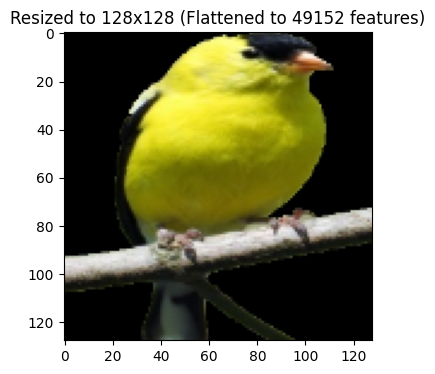

Flattened feature vector shape: (49152,)


In [29]:
resized, flattened = preprocess_for_knn(image_path)
if resized is not None:
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Resized to {resized.shape[1]}x{resized.shape[0]} (Flattened to {flattened.shape[0]} features)")
    plt.show()
    print("Flattened feature vector shape:", flattened.shape)

Now we need our dataset. We will get the images and extract the type of bird from the folder name.

In [18]:
data_dir = "data/Bird_Species_Dataset"
dataset = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        img_path = os.path.join(root, file)
        dataset.append(img_path)
        labels.append(os.path.basename(root))

Now we preprocess the images to get our features, we match each image in X to it's correct label in valid_labels through their indices.

In [19]:
data_dir = "data/Bird_Species_Dataset"
dataset = []
labels = []

#fetches the paths and bird types of each image and puts them in separate arrays
for root, dirs, files in os.walk(data_dir):
    for file in files:
        img_path = os.path.join(root, file)
        dataset.append(img_path)
        labels.append(os.path.basename(root))